In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Getting Started Outbrain: ETL with NVTabular

## Overview

In this notebook we will do preprocessing and feature engineering using [Kaggle Outbrain dataset](https://www.kaggle.com/c/outbrain-click-prediction).

**Learning objectives**

In this notebook, we learn how to 

- Use LambdaOp for custom row-wise dataframe manipulations with NVTabular
- Preprocess single-hot categorical input features with NVTabular
- Apply TargetEncoding to categorical features
- Create a custom operator to create time features
- Apply ColumnSimilarity to calculate the similarity between two columns using tf-idf metric

In [5]:
import os
import glob
import time
import datetime
import math
import graphviz
import gc

import cupy
import cudf
import rmm
from numba import cuda
import numpy as np

import nvtabular as nvt
from nvtabular.io import Shuffle
from nvtabular.ops import Normalize, FillMedian, FillMissing, Categorify, LogOp, LambdaOp, JoinGroupby, TargetEncoding, get_embedding_sizes, Rename
from nvtabular.ops.column_similarity import ColumnSimilarity

from nvtabular import ColumnGroup, Workflow

First, we set where the dataset should be saved once processed (OUTPUT_BUCKET_FOLDER), as well as where the dataset originally resides (DATA_BUCKET_FOLDER).

In [6]:
DATA_BUCKET_FOLDER = os.environ.get("INPUT_DATA_DIR", "/outbrain/")
OUTPUT_BUCKET_FOLDER = os.environ.get("OUTPUT_DATA_DIR", "/outbrain/")

In [7]:
DATA_BUCKET_FOLDER

'/outbrain/'

Let's read our saved train and valid datasets.

In [8]:
train_filename = os.path.join(OUTPUT_BUCKET_FOLDER, "train_gdf.parquet")
valid_filename = os.path.join(OUTPUT_BUCKET_FOLDER, "valid_gdf.parquet")

In [5]:
train_filename

'/outbrain/train_gdf.parquet'

## Preparing documents metadata

Let's create the output directories to store the preprocessed parquet files.

In [7]:
output_train_dir = os.path.join(OUTPUT_BUCKET_FOLDER, 'train/')
output_valid_dir = os.path.join(OUTPUT_BUCKET_FOLDER, 'valid/')
! mkdir -p $output_train_dir
! mkdir -p $output_valid_dir

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


We read in three more cudf data frames, <i>documents categories</i>, <i>topics</i>, and <i>entities</i>, and use them to create sparse matrices in cupy. We will use these later to calculate cosine similarity between event document (landing page context) and ad document profile vectors (TF-IDF), i.e., how close in profile an ad is to the page that it is being displayed.

In [8]:
documents_categories_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_categories.csv')
documents_topics_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_topics.csv')
documents_entities_cudf = cudf.read_csv(DATA_BUCKET_FOLDER + 'documents_entities.csv')
# read in document categories/topics/entities as cupy sparse matrices
def df_to_coo(df, row="document_id", col=None, data="confidence_level"):
    return cupy.sparse.coo_matrix((df[data].values, (df[row].values, df[col].values)))

categories = df_to_coo(documents_categories_cudf, col="category_id")
topics = df_to_coo(documents_topics_cudf, col="topic_id")
documents_entities_cudf['entity_id'] = documents_entities_cudf['entity_id'].astype("category").cat.codes
entities = df_to_coo(documents_entities_cudf, col="entity_id")

documents_categories_cudf = documents_topics_cudf = documents_entities_cudf =  None

## Initiate NVTabular Workflow

Now that our datasets, sparse matrices and udf are created, we can begin laying the groundwork for NVTabular. NVTabular requires input features to be defined as groups of columns , so we define our ColumnGroup features at this step. Note that feature engineering and preprocessing often happens to sets of columns, so we adopt that method and require the user to specify continuous and categoricals along with the target as lists within ColumnGroup.

At this point, our data still isn’t in a form that’s ideal for consumption by our W&D model that we will train in the next notebook. There are missing values, and our categorical variables are still represented by random, discrete identifiers, and need to be transformed into contiguous indices for embedding lookups. The distributions of our continuous variables are uncentered. We also would like to create new features that will help to increase the model accuracy.

Let's begin to create and process features using NVTabular ops:
 * <i>geo_location_state</i> and <i>geo_location_country</i> are created by stripping geo_location using the `LambdaOp`
 * <i>publish_time_days_since_published</i> and <i>publish_time_promo_days_since_published</i> features are created using the `calculate_delta` function in a `LambdaOp`
 * Missing values are filled using median value depending on the feature using `FillMedian()`op
 * Continuous features are log transformed with the `LogOp()`.
 
`Categorify` op is used for categorification, i.e. encoding of categorical features. Categorify op takes a param called `freq_threshold` which is used for frequency capping. This handy functionality will map all categories which occur in the dataset with some threshold level of infrequency to the _same_ index, keeping the model from overfitting to sparse signals. We don't apply  frequency thresholds in this example, but one can easily create a frequency threshold dictionary, assign a custom threshold value for each categorical feature, and feed that dictionary into the `Categorify` op as `freq_threshold` param.

One of the important part of building recommender systems is to do feature engineering. As a very promising feature engineering technique, `Target Encoding` processes the categorical features and makes them easier accessible to the model during training and validation. *Target Encoding (TE)* has emerged as being both effective and efficient in many data science projects. For example, it is the major component of Nvidia Kaggle Grandmasters team’s [winning solution](https://medium.com/rapids-ai/winning-solution-of-recsys2020-challenge-gpu-accelerated-feature-engineering-and-training-for-cd67c5a87b1f) of [Recsys Challenge 2020](http://www.recsyschallenge.com/2020/). TE calculates the statistics from a target variable grouped by the unique values of one or more categorical features. For example in a binary classification problem, it calculates the probability that the target is true for each category value - a simple mean. In other words, for each distinct element in feature <b>$x$</b> we are going to compute the average of the corresponding values in target <i>y</i>. Then we are going to replace each $x_{i}$ with the corresponding mean value. For more details on TargetEncoding please visit [here](https://medium.com/rapids-ai/target-encoding-with-rapids-cuml-do-more-with-your-categorical-data-8c762c79e784) and [here](https://github.com/rapidsai/deeplearning/blob/main/RecSys2020Tutorial/03_3_TargetEncoding.ipynb).

Here, we apply Target Encoding to certain categorical features with *kfold* of 5 and *smoothing* of 20 to avoid overfitting using [TargetEncoding op](https://github.com/NVIDIA/NVTabular/blob/a0141d0a710698470160bc2cbc42b18ce2d49133/nvtabular/ops/target_encoding.py).

## Feature Engineering

Below, we create a custom operator that calculates the time difference between a specified time column (either publish_time or publish_time_promo) and timestamp. This is used to calculate <i>time elapsed since publication</i> between the landing page and the ad.

In [9]:
#To save disk space, the timestamps in the entire dataset are relative to the first time in the dataset. 
#To recover the actual epoch time of the visit, we add 1465876799998 to the timestamp.
TIMESTAMP_DELTA = 1465876799998

from nvtabular.ops import Operator

class DaysSincePublished(Operator):
    def transform(self, columns, gdf):
        for column in columns:
            col = gdf[column]
            col.loc[col == ""] = None
            col = col.astype('datetime64[ns]')
            timestamp = (gdf['timestamp']+TIMESTAMP_DELTA).astype('datetime64[ms]')
            delta = (timestamp - col).dt.days
            gdf[column + "_since_published"] = delta * (delta >=0) * (delta<=10*365)
        return gdf
            
    def output_column_names(self, columns):
        return [column + "_since_published" for column in columns]
            
    def dependencies(self):
        return ["timestamp"]

In [10]:
# geo processing: apply two different lambda operators to the ‘geo_location’ column, and 
# extract the country/state from the geo_location value. The geo_location column
# looks something like "US>CA>12345", so we're using string slicing to pull out the country
# and the country+state then 
geo_location = ColumnGroup(["geo_location"])
country = geo_location >> (lambda col: col.str.slice(0, 2)) >> Rename(postfix="_country")
state = geo_location >> (lambda col: col.str.slice(0, 5)) >> Rename(postfix="_state")
geo_features = geo_location + country + state

# categoricals processing: categorify certain input columns as well as the geo features
cats = ColumnGroup(['ad_id', 'document_id', 'platform', 'document_id_promo', 'campaign_id', 'advertiser_id', 'source_id', 'publisher_id', 'source_id_promo', 'publisher_id_promo'])
cat_features = geo_features + cats >> Categorify()

# Apply TargetEncoding to certain categoricals with kfold of 1 and smoothing of 20
te_features = cats >> TargetEncoding("clicked", kfold=5, p_smooth=20)
 
# process dates using the ‘DaysSincePublished’ custom operator
dates = ["publish_time", "publish_time_promo"]
date_features = dates >> DaysSincePublished() >> FillMedian() >> LogOp()

Let's visualize our calculation graph with the column groups we used and created so far.

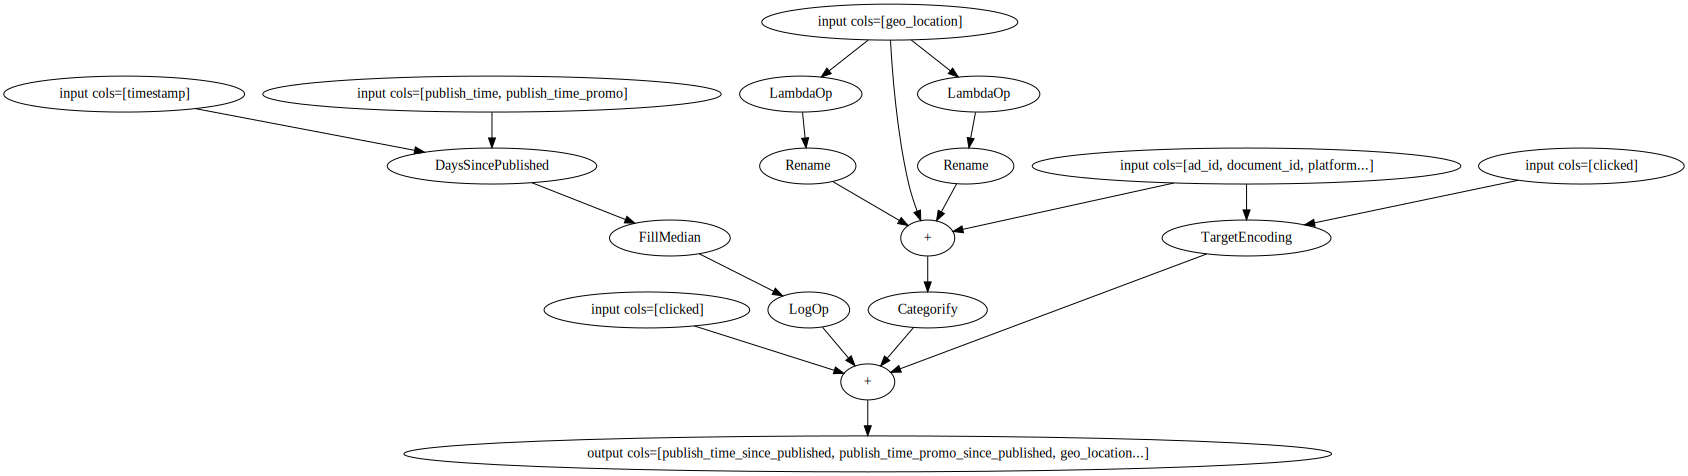

In [11]:
features = date_features + cat_features + te_features + "clicked"
features.graph

A user might sometimes be interested to continue reading about the same topics of the current page. Computing the similarity between the textual content of the current page and the pages linked to the displayed ads, can be a relevant feature for a model that predicts which ad the user would click next. A simple, yet effective way to compute the similarity between documents is generating the TF-IDF vectors for each of them, which captures their most relevant terms, and then computing the cosine similarity between those vectors.
 
Below, we calculate <i>doc_event_doc_ad_sim_categories</i>, <i>topics</i>, and <i>entities</i> using the `ColumnSimilarity` op, which utilizes the sparse categories, topics, and entities matrices that were created above to calculate landing page similarity for categories, topics, and entities. We calculate Cosine similarity between event doc (landing page) and ad doc aspects vectors (TF-IDF). Creating these extra features help to improve model accuracy and predictability. 

Note that we rename the column names to avoid duplicated column names.

In [12]:
sim_features_categ = [["document_id", "document_id_promo"]] >> ColumnSimilarity(categories, metric='tfidf', on_device=False) >> Rename(postfix="_categories")
sim_features_topics= [["document_id", "document_id_promo"]] >> ColumnSimilarity(topics, metric='tfidf', on_device=False) >> Rename(postfix="_topics")
sim_features_entities= [["document_id", "document_id_promo"]] >> ColumnSimilarity(entities, metric='tfidf', on_device=False) >> Rename(postfix="_entities")
sim_features = sim_features_categ + sim_features_topics +  sim_features_entities

/nvtabular/nvtabular/ops/column_similarity.py:229: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(N / np.bincount(X.col))


In [13]:
# The workflow is created with the output node of the graph
workflow = nvt.Workflow(features + sim_features)

We then create an NVTabular Dataset object both for train and validation sets. We calculate statistics for this workflow on the input dataset, i.e. on our training set, using the `workflow.fit()` method so that our <i>Workflow</i> can use these stats to transform any given input. When our <i>Workflow</i> transorms our datasets and, we also save the results out to parquet files for fast reading at train time.

In [14]:
train_dataset = nvt.Dataset(train_filename)
valid_dataset = nvt.Dataset(valid_filename)

# Calculate statistics on the training set
workflow.fit(train_dataset)

In [15]:
# use the calculated statistics to transform the train/valid datasets 
# and write out each as parquet
workflow.transform(train_dataset).to_parquet(output_path=output_train_dir, shuffle=Shuffle.PER_PARTITION, out_files_per_proc=5)
workflow.transform(valid_dataset).to_parquet(output_path=output_valid_dir)

We can save the stats from the workflow and load it anytime, so we can run training without doing preprocessing.

In the next notebooks, we will train a deep learning model. Our training pipeline requires information about the data schema to define the neural network architecture. We will save the NVTabular workflow to disk so that we can restore it in the next notebooks.

In [16]:
workflow.save(os.path.join(OUTPUT_BUCKET_FOLDER, 'workflow'))

In [17]:
workflow.input_dtypes

{'source_id': dtype('float64'),
 'publisher_id_promo': dtype('float64'),
 'ad_id': dtype('int64'),
 'publish_time_promo': dtype('O'),
 'timestamp': dtype('int64'),
 'document_id': dtype('int64'),
 'advertiser_id': dtype('int64'),
 'source_id_promo': dtype('float64'),
 'publish_time': dtype('O'),
 'clicked': dtype('int64'),
 'document_id_promo': dtype('int64'),
 'publisher_id': dtype('float64'),
 'platform': dtype('float64'),
 'geo_location': dtype('O'),
 'campaign_id': dtype('int64')}

In [19]:
from nvtabular.inference.triton import generate_nvtabular_model
generate_nvtabular_model(workflow, "outbrain_nvt", "/outbrain/tf_models/outbrain_nvt/")

name: "outbrain_nvt"
input {
  name: "source_id"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
input {
  name: "publisher_id_promo"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
input {
  name: "ad_id"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "publish_time_promo"
  data_type: TYPE_STRING
  dims: -1
  dims: 1
}
input {
  name: "timestamp"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "document_id"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "advertiser_id"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "source_id_promo"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
input {
  name: "publish_time"
  data_type: TYPE_STRING
  dims: -1
  dims: 1
}
input {
  name: "clicked"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "document_id_promo"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "publisher_id"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
input {
  name: "platform"
  data_type: TYP

# Load workflow

In [9]:
workflow = Workflow.load(os.path.join(OUTPUT_BUCKET_FOLDER, 'workflow'))

In [18]:
workflow.input_dtypes.keys()

dict_keys(['platform', 'source_id_promo', 'campaign_id', 'advertiser_id', 'source_id', 'publisher_id_promo', 'document_id_promo', 'ad_id', 'publisher_id', 'timestamp', 'document_id', 'geo_location', 'publish_time', 'clicked', 'publish_time_promo'])

In [23]:
list(workflow.input_dtypes.keys())

['platform',
 'source_id_promo',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id_promo',
 'document_id_promo',
 'ad_id',
 'publisher_id',
 'timestamp',
 'document_id',
 'geo_location',
 'publish_time',
 'clicked',
 'publish_time_promo']

In [1]:
#workflow.column_group.graph

In [6]:
valid_dataset = nvt.Dataset(valid_filename)

In [ ]:
# Write to new "shuffled" and "processed" dataset
workflow.transform(valid_dataset).to_parquet(output_path='./valid/', out_files_per_proc=10, shuffle=False)

In [8]:
valid_df = cudf.read_parquet('./valid/0.6d7fc3d1d81c485a8bcf58c5966eb457.parquet')

In [9]:
valid_df

,publish_time_since_published,publish_time_promo_since_published,geo_location,geo_location_country,geo_location_state,ad_id,document_id,platform,document_id_promo,campaign_id,...,TE_campaign_id_clicked,TE_advertiser_id_clicked,TE_source_id_clicked,TE_publisher_id_clicked,TE_source_id_promo_clicked,TE_publisher_id_promo_clicked,clicked,document_id_document_id_promo_sim_categories,document_id_document_id_promo_sim_topics,document_id_document_id_promo_sim_entities
0,0.000000,0.000000,2706,216,2370,160842,405383,3,47575,21830,...,0.252923,0.176548,0.220186,0.218234,0.176565,-0.775049,0,0.000000,0.0,0.0
1,0.000000,0.000000,2521,216,2350,139871,412675,3,30281,12266,...,0.202355,0.193839,0.187939,0.189784,0.202680,-0.775023,0,0.000000,0.0,0.0
2,1.098612,6.878326,2613,216,2361,140616,421500,3,9389,19613,...,0.202601,0.210658,0.248128,0.248128,0.114959,0.053273,1,0.000000,0.0,0.0
3,4.110874,5.252274,266,40,266,163756,371587,3,23657,22100,...,0.092745,0.061812,0.189494,0.189494,0.061734,-0.773894,0,0.994363,0.0,0.0
4,1.098612,4.510859,2371,216,2331,192858,164088,2,71001,24125,...,0.123941,0.109333,0.151633,0.151427,0.118282,0.119006,0,0.990905,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737589,4.718499,1.386294,2613,216,2361,413304,263176,3,142028,31135,...,0.118619,0.118619,0.239679,0.236213,0.171389,0.173565,0,0.000000,0.0,0.0
2737590,5.537334,4.290460,2705,216,2370,121439,209774,3,45297,18091,...,0.575731,0.575222,0.226757,0.226757,0.574365,-0.773894,0,0.000000,0.0,0.0
2737591,1.098612,4.564348,2392,216,2336,105418,682982,3,34195,11706,...,0.346086,0.315034,0.225610,0.225113,0.345983,-0.773894,0,0.000000,0.0,0.0
2737592,1.098612,5.351858,2621,216,2361,120623,144077,4,22582,17986,...,0.314228,0.266767,0.195666,0.214877,0.283054,-0.775023,0,0.997422,0.0,0.0


## Reviewing processed data

In [16]:
TRAIN_PATHS = sorted(glob.glob(os.path.join(OUTPUT_BUCKET_FOLDER, 'train/*.parquet')))
VALID_PATHS = sorted(glob.glob(os.path.join(OUTPUT_BUCKET_FOLDER, 'valid/*.parquet')))
TRAIN_PATHS, VALID_PATHS

(['/outbrain/train/0.11e781ddc5604d3c8f05125c13e9668b.parquet',
  '/outbrain/train/1.69bc90d84bfa472190776988e357ca4d.parquet',
  '/outbrain/train/2.4cefdcd658264a80b2e889c8ea1a1106.parquet',
  '/outbrain/train/3.3b9dd97508e347b28aa6a2ceefdcc076.parquet',
  '/outbrain/train/4.fce9eebe7871421786d03903cba094d6.parquet'],
 ['/outbrain/valid/0.e6ec5ce021654f1299fb7751b6b51ab7.parquet'])

In [17]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,publish_time_since_published,publish_time_promo_since_published,geo_location,geo_location_country,geo_location_state,ad_id,document_id,platform,document_id_promo,campaign_id,...,TE_campaign_id_clicked,TE_advertiser_id_clicked,TE_source_id_clicked,TE_publisher_id_clicked,TE_source_id_promo_clicked,TE_publisher_id_promo_clicked,clicked,document_id_document_id_promo_sim_categories,document_id_document_id_promo_sim_topics,document_id_document_id_promo_sim_entities
0,5.883322,3.583519,2613,216,2361,263935,147376,4,5460,5760,...,0.061908,0.071860,0.250518,0.250518,0.082026,-0.775023,0,0.000000,0.0,0.0
1,1.098612,4.127134,2365,216,2331,109398,415566,3,44482,15758,...,0.254974,0.254974,0.184724,0.193195,0.256537,-0.773894,0,0.000000,0.0,0.0
2,1.098612,4.564348,257,40,257,183107,401204,3,77078,23509,...,0.316161,0.316161,0.180701,0.180701,0.316176,-0.773894,0,0.992619,0.0,0.0
3,7.148346,5.789960,2656,216,2364,144134,32763,4,35547,643,...,0.033766,0.042248,0.185800,0.183644,0.038108,-0.775023,0,0.963620,0.0,0.0
4,0.000000,2.564949,2699,216,2369,198997,401740,3,78791,23865,...,0.498238,0.352447,0.219932,0.213906,0.352510,0.355666,0,0.983698,0.0,0.0


# SEND REQUEST TO TRITON FOR NVT MODEL

In [2]:
# External dependencies
import os

from tritonclient.utils import *
import tritonclient.grpc as grpcclient
import nvtabular
import cudf
from timeit import default_timer as timer
from datetime import timedelta

In [3]:
!curl -i 10.110.20.127:8000/v2/health/ready

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
HTTP/1.1 200 OK
Content-Length: 0
Content-Type: text/plain



In [11]:
workflow.column_group.input_column_names

['publish_time_since_published',
 'publish_time_promo_since_published',
 'geo_location',
 'geo_location_country',
 'geo_location_state',
 'ad_id',
 'document_id',
 'platform',
 'document_id_promo',
 'campaign_id',
 'advertiser_id',
 'source_id',
 'publisher_id',
 'source_id_promo',
 'publisher_id_promo',
 'TE_ad_id_clicked',
 'TE_document_id_clicked',
 'TE_platform_clicked',
 'TE_document_id_promo_clicked',
 'TE_campaign_id_clicked',
 'TE_advertiser_id_clicked',
 'TE_source_id_clicked',
 'TE_publisher_id_clicked',
 'TE_source_id_promo_clicked',
 'TE_publisher_id_promo_clicked',
 'clicked',
 'document_id_document_id_promo_sim_categories',
 'document_id_document_id_promo_sim_topics',
 'document_id_document_id_promo_sim_entities']

In [26]:
# read in the workflow (to get input/output schema to call triton with)

workflow = nvtabular.Workflow.load("/model/tf_models/outbrain_nvt/1/workflow")

# read in a batch of data to get transforms for
batch = cudf.read_parquet(valid_filename, num_rows=3)[list(workflow.input_dtypes.keys())]

# print(batch, "\n")
batch

,platform,source_id_promo,campaign_id,advertiser_id,source_id,publisher_id_promo,document_id_promo,ad_id,publisher_id,timestamp,document_id,geo_location,publish_time,clicked,publish_time_promo
0,2.0,7941.0,22122,1685,10345.0,<NA>,850713,183855,440.0,4141173,1788099,US>TX>600,2016-06-13 21:00:00,0,<NA>
1,2.0,8254.0,15431,769,1675.0,<NA>,1116986,187797,236.0,5272727,1794963,US>CA>807,2016-06-14 00:00:00,0,2015-09-28 00:00:00
2,3.0,8230.0,25978,2146,105.0,<NA>,1100702,244543,206.0,645068,1783066,US>MN>702,2016-06-13 19:00:00,0,2016-02-18 06:00:00


In [30]:
batch.dtypes

platform              float64
source_id_promo       float64
campaign_id             int64
advertiser_id           int64
source_id             float64
publisher_id_promo    float64
document_id_promo       int64
ad_id                   int64
publisher_id          float64
timestamp               int64
document_id             int64
geo_location           object
publish_time           object
clicked                 int64
publish_time_promo     object
dtype: object

In [54]:
workflow.output_dtypes

{'publish_time_since_published': dtype('float32'),
 'publish_time_promo_since_published': dtype('float32'),
 'geo_location': dtype('int64'),
 'geo_location_country': dtype('int64'),
 'geo_location_state': dtype('int64'),
 'ad_id': dtype('int64'),
 'document_id': dtype('int64'),
 'platform': dtype('int64'),
 'document_id_promo': dtype('int64'),
 'campaign_id': dtype('int64'),
 'advertiser_id': dtype('int64'),
 'source_id': dtype('int64'),
 'publisher_id': dtype('int64'),
 'source_id_promo': dtype('int64'),
 'publisher_id_promo': dtype('int64'),
 'TE_ad_id_clicked': dtype('float64'),
 'TE_document_id_clicked': dtype('float64'),
 'TE_platform_clicked': dtype('float64'),
 'TE_document_id_promo_clicked': dtype('float64'),
 'TE_campaign_id_clicked': dtype('float64'),
 'TE_advertiser_id_clicked': dtype('float64'),
 'TE_source_id_clicked': dtype('float64'),
 'TE_publisher_id_clicked': dtype('float64'),
 'TE_source_id_promo_clicked': dtype('float64'),
 'TE_publisher_id_promo_clicked': dtype('fl

In [41]:
# convert the batch to a triton inputs
columns = [(col, batch[col][0:3]) for col in list(workflow.input_dtypes.keys())]
inputs = []

# col_dtypes = [np.int64, np.int64]

col_dtypes = [np.float64, np.float64, np.int64, np.int64, np.float64, np.float64, np.int64, np.int64,  np.float64, np.int64, np.int64,
              np.object, np.object, np.int64, np.object] 

for i, (name, col) in enumerate(columns):
    d = col.values_host.astype(col_dtypes[i])
    d = d.reshape(len(d),1)
    inputs.append(grpcclient.InferInput(name, d.shape, np_to_triton_dtype(col_dtypes[i])))
    inputs[i].set_data_from_numpy(d)

<ipython-input-41-c0c2f55f4055>:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object, np.object, np.int64, np.object]


In [ ]:
# placeholder variables for the output
outputs = [grpcclient.InferRequestedOutput(name) for name in workflow.column_group.columns]
# make the request
# replace <localhost> with your host ip address.
with grpcclient.InferenceServerClient("10.110.20.127:8001") as client:
    response = client.infer("outbrain_nvt", inputs, request_id="1",outputs=outputs)

InferenceServerException: [StatusCode.INTERNAL] GRPC Execute Failed, message: Traceback (most recent call last):
  File "/opt/tritonserver/backends/python/startup.py", line 273, in Execute
    responses = self.model_instance.execute(inference_requests)
  File "/model/tf_models/outbrain_nvt/1/model.py", line 103, in execute
    output_df = nvtabular.workflow._transform_partition(
  File "/nvtabular/nvtabular/workflow.py", line 316, in _transform_partition
    parent_df = _transform_partition(root_df, [parent])
  File "/nvtabular/nvtabular/workflow.py", line 316, in _transform_partition
    parent_df = _transform_partition(root_df, [parent])
  File "/nvtabular/nvtabular/workflow.py", line 316, in _transform_partition
    parent_df = _transform_partition(root_df, [parent])
  File "/nvtabular/nvtabular/workflow.py", line 331, in _transform_partition
    df = column_group.op.transform(column_group.input_column_names, df)
  File "<ipython-input-9-b58fdc7b39e2>", line 12, in transform
  File "/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/series.py", line 2190, in astype
    raise e
  File "/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/series.py", line 2182, in astype
    data = self._column.astype(dtype)
  File "/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/column.py", line 1005, in astype
    return self.as_datetime_column(dtype, **kwargs)
  File "/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py", line 4877, in as_datetime_column
    format = datetime.infer_format(
  File "/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/datetime.py", line 385, in infer_format
    raise ValueError("Given date string not likely a datetime.")
ValueError: Given date string not likely a datetime.


In [ ]:
# convert output from triton back to a nvt dataframe  
output = cudf.DataFrame({col: response.as_numpy(col).T[0] for col in workflow.column_group.columns})
print(output)